Use if on Google Colab

In [ ]:
!pip install numpy scikit-learn matplotlib pandas google-colab requests


import requests
url = 'https://drive.usercontent.google.com/download?id=1WQvAWjBdhTX0vyVV-Ew62sVgtAOiV8S0&export=download&authuser=0'

# Download the file
response = requests.get(url)
with open('clustering.csv', 'wb') as f:
    f.write(response.content)


# Clustering From Scratch
Applying K-Means, DBSCAN, and HDBSCAN to the provided dataset using only NumPy, Pandas, and Matplotlib.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('clustering.csv')
X = data[['x', 'y']].to_numpy()


In [2]:
def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 5))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for color, lbl in zip(colors, unique_labels):
        mask = labels == lbl
        if lbl == -1:
            plt.scatter(X[mask, 0], X[mask, 1], s=10, c=[color], marker='x', label='noise')
        else:
            plt.scatter(X[mask, 0], X[mask, 1], s=10, c=[color], label=f'cluster {lbl}')
    plt.title(title)
    plt.legend(loc='best', fontsize=8)
    plt.show()

## K-Means from Scratch
Simple iterative centroid-based clustering implemented with plain functions (no classes).

**Components used below**
- **`initialize_centroids`**: randomly picks `k` points from the dataset as initial centroids.
- **`assign_clusters`**: assigns each point to the closest centroid using Euclidean distance.
- **`update_centroids`**: recomputes each centroid as the mean of the points assigned to it (keeps the old centroid if a cluster becomes empty).
- **`kmeans_fit_predict`**: runs the full K-Means loop: initialize → assign → update → repeat until centroids stop moving or the max iteration count is reached; returns the final cluster labels (and centroids).

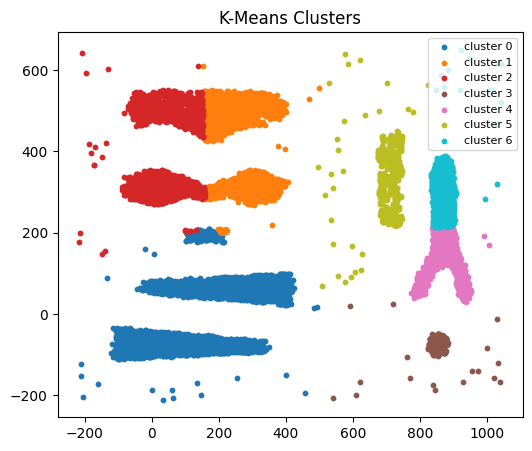

In [21]:
def initialize_centroids(X, k, random_state=0):
    """Randomly choose k points from X as initial centroids.

    X: (n_samples, n_features) data array
    k: number of clusters
    random_state: seed for reproducibility
    """
    rng = np.random.default_rng(random_state)
    indices = rng.choice(len(X), size=k, replace=False)
    return X[indices].copy()


def assign_clusters(X, centroids):
    """Assign each point in X to the nearest centroid.

    Returns an array of shape (n_samples,) with the cluster index for each point.
    """
    diff = X[:, None, :] - centroids[None, :, :]
    distances = np.sqrt(np.sum(diff * diff, axis=2))
    return np.argmin(distances, axis=1)


def kmeans_update_centroids(X, labels, centroids):
    """Recompute centroids as the mean of assigned points.

    If a cluster becomes empty, keep its previous centroid.
    """
    k = centroids.shape[0]
    new_centroids = np.empty_like(centroids)
    for idx in range(k):
        points = X[labels == idx]
        if len(points) == 0:
            new_centroids[idx] = centroids[idx]
        else:
            new_centroids[idx] = points.mean(axis=0)
    return new_centroids


def kmeans_fit_predict(X, k, max_iters=100, random_state=0):
    """Run K-Means clustering and return (labels, centroids).

    X: data array
    k: number of clusters
    max_iters: maximum number of iterations
    random_state: seed for centroid initialization
    """
    centroids = initialize_centroids(X, k, random_state=random_state)
    for _ in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = kmeans_update_centroids(X, labels, centroids)
        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            break
        centroids = new_centroids
    return labels, centroids


# Run K-Means with function-based implementation
kmeans_labels, kmeans_centroids = kmeans_fit_predict(X, k=7, max_iters=50, random_state=3)
plot_clusters(X, kmeans_labels, 'K-Means Clusters')


## DBSCAN from Scratch

Density-based clustering that marks low-density points as noise.

**Components used below**

- **`dbscan_region_query`**: finds all points within distance `eps` of a given point (its neighborhood).
- **`dbscan_expand_cluster`**: starting from a core point, grows a cluster by repeatedly adding density-reachable neighbors; marks points as part of the current cluster or as noise.
- **`dbscan_fit_predict`**: main driver that loops over all points, launches `dbscan_expand_cluster` when it finds an unvisited point, and returns final labels (with noise as `-1` and clusters later shifted to start at `0`).

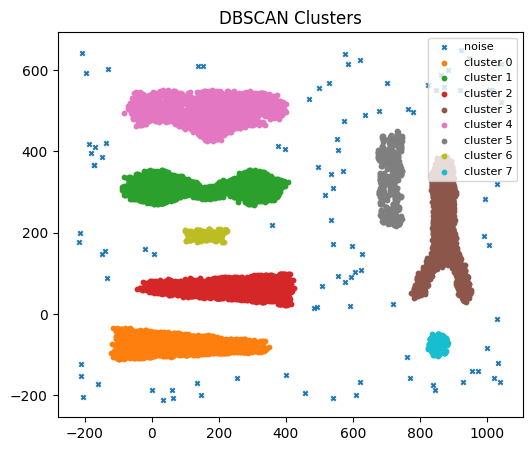

In [23]:
def dbscan_region_query(X, idx, eps):
    """Return indices of all points within distance eps of point idx."""
    distances = np.linalg.norm(X - X[idx], axis=1)
    return np.where(distances <= eps)[0]


def dbscan_expand_cluster(X, labels, idx, cluster_id, eps, min_samples):
    """Grow a cluster from point idx if it is a core point.

    Returns True if a new cluster was formed, False if idx is noise.
    """
    seeds = list(dbscan_region_query(X, idx, eps))
    if len(seeds) < min_samples:
        labels[idx] = -1  # mark as noise (for now)
        return False

    labels[idx] = cluster_id
    i = 0
    while i < len(seeds):
        point = seeds[i]
        if labels[point] == -1:
            labels[point] = cluster_id  # previously noise, now part of cluster
        if labels[point] != 0:
            i += 1
            continue
        labels[point] = cluster_id
        neighbors = dbscan_region_query(X, point, eps)
        if len(neighbors) >= min_samples:
            # add new neighbors that are not already in seeds
            seeds.extend([n for n in neighbors if n not in seeds])
        i += 1
    return True


def dbscan_fit_predict(X, eps, min_samples):
    """Run DBSCAN and return labels with noise=-1 and clusters starting at 1.

    (We shift them to start at 0 right after this function, to match other code.)
    """
    labels = np.zeros(len(X), dtype=int)  # 0 = unvisited
    cluster_id = 0
    for idx in range(len(X)):
        if labels[idx] != 0:
            continue
        if dbscan_expand_cluster(X, labels, idx, cluster_id + 1, eps, min_samples):
            cluster_id += 1
    labels[labels == 0] = -1  # remaining unlabeled points are noise
    return labels


# Run DBSCAN with function-based implementation
dbscan_labels = dbscan_fit_predict(X, eps=25.0, min_samples=5)
dbscan_labels = np.where(dbscan_labels == -1, -1, dbscan_labels - 1)
plot_clusters(X, dbscan_labels, 'DBSCAN Clusters')


## HDBSCAN from Scratch (simplified)
Hierarchy over density via mutual reachability distances and a stability-based cluster selection.

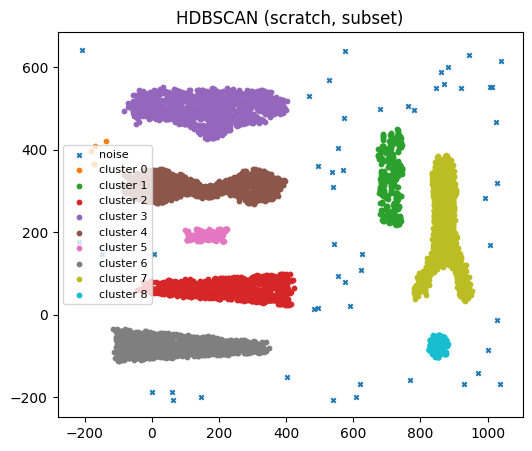

In [16]:
def pairwise_distances(X):
    diff = X[:, None, :] - X[None, :, :]
    return np.sqrt(np.sum(diff * diff, axis=2))

def core_distances(X, min_samples):
    """Return core distance for each point: distance to its (min_samples)-th nearest neighbor.
    X: (n, d) array, min_samples: int
    """
    dists = pairwise_distances(X)                    # full pairwise distance matrix (n,n)
    sorted_dists = np.sort(dists, axis=1)            # sort distances for each point
    # index min_samples-1 to keep same convention as earlier (includes self at index 0)
    return sorted_dists[:, min_samples - 1]          # shape (n,)

def mutual_reachability_distances(X, min_samples):
    """Compute mutual reachability distance matrix:
    mreach(i,j) = max( pairwise(i,j), core(i), core(j) )
    """
    core = core_distances(X, min_samples)            # core distance per point, shape (n,)
    pairwise = pairwise_distances(X)                 # pairwise distances, shape (n,n)
    # broadcast core to (n,n) and take elementwise maximum
    return np.maximum(pairwise, np.maximum(core[:, None], core[None, :]))

def kruskal_mst(mreach):
    """Kruskal's algorithm on a dense symmetric matrix to return MST edges as (u,v,weight)."""
    n = mreach.shape[0]

    # 1) Build edge list for i < j (upper triangle, ignore self-loops)
    edges = []
    for i in range(n):
        for j in range(i + 1, n):
            edges.append((i, j, mreach[i, j]))

    # 2) Sort edges by weight (ascending)
    edges.sort(key=lambda e: e[2])

    # 3) Union-Find (Disjoint Set Union) for cycle detection
    parent = list(range(n))
    rank = [0] * n

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]  # path compression
            x = parent[x]
        return x

    def union(x, y):
        rx, ry = find(x), find(y)
        if rx == ry:
            return False
        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1
        return True

    # 4) Build MST by taking smallest edges that connect different components
    mst_edges = []
    for u, v, w in edges:
        if union(u, v):          # only add if it connects two different components
            mst_edges.append((u, v, w))
            if len(mst_edges) == n - 1:
                break

    return mst_edges
def build_cluster_tree(n_points, edges):
    """Build a hierarchical merge tree from MST edges sorted by weight."""
    edges_sorted = sorted(edges, key=lambda x: x[2])  # sort by increasing distance
    next_id = n_points
    parent = {i: i for i in range(n_points)}
    size = {i: 1 for i in range(n_points)}
    birth = {i: 0.0 for i in range(n_points)}        # birth distance for leaves
    death = {i: None for i in range(n_points)}
    children = {i: [] for i in range(n_points)}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    for u, v, w in edges_sorted:
        ru, rv = find(u), find(v)
        if ru == rv:
            continue
        level = w                                   # use distance directly
        parent[ru] = next_id
        parent[rv] = next_id
        parent[next_id] = next_id
        children[next_id] = [ru, rv]
        birth[next_id] = level
        death[ru] = level
        death[rv] = level
        size[next_id] = size[ru] + size[rv]
        size[ru] = 0
        size[rv] = 0
        next_id += 1

    root = find(0)
    # root dies at the largest merge distance
    max_level = edges_sorted[-1][2] if edges_sorted else 0.0
    death[root] = max_level

    stability = {}
    for cid in range(next_id):
        b = birth.get(cid, 0.0)
        d = death.get(cid, None)
        s = max(size.get(cid, 0), 0)
        if d is not None:
            stability[cid] = (d - b) * max(s, 1)
    return root, children, stability


def select_clusters(root, children, stability, min_stability=0.5):
    """Select clusters by a simple stability threshold."""
    # internal nodes = those that have children
    internal_nodes = [n for n, ch in children.items() if len(ch) > 0]

    # drop root and very unstable nodes
    candidates = [
        n for n in internal_nodes
        if n != root and stability.get(n, 0.0) >= min_stability
    ]

    # label_points will process in this order; put most stable last so they win overlaps
    candidates.sort(key=lambda n: stability.get(n, 0.0))

    return candidates


def label_points(n_points, selected, children):
    """Assign final cluster labels to original points given selected cluster nodes.
    Points not covered by any selected node remain noise (-1).
    """
    labels = np.full(n_points, -1, dtype=int)
    cluster_id = 0

    def assign(node, cid):
        # if node is an original point, label it
        if node < n_points:
            labels[node] = cid
            return
        # otherwise, recurse into children
        for child in children.get(node, []):
            assign(child, cid)

    for node in selected:
        assign(node, cluster_id)
        cluster_id += 1
    return labels

def hdbscan_scratch(X, min_samples=5):
    """Top-level simplified HDBSCAN: compute mutual reachability, MST, build tree,
    select clusters by stability, and label points."""
    mreach = mutual_reachability_distances(X, min_samples)   # (n,n)
    edges = kruskal_mst(mreach)                              # MST edges (n-1)
    root, children, stability = build_cluster_tree(len(X), edges)
    selected = select_clusters(root, children, stability, min_stability=20)
    labels = label_points(len(X), selected, children)
    return labels

# run simplified HDBSCAN (adjust min_samples as needed)
idx = np.random.default_rng(0).choice(len(X), size=7000, replace=False)
X_small = X[idx]

hdbscan_labels = hdbscan_scratch(X_small, min_samples=5)
plot_clusters(X_small, hdbscan_labels, "HDBSCAN (scratch, subset)")


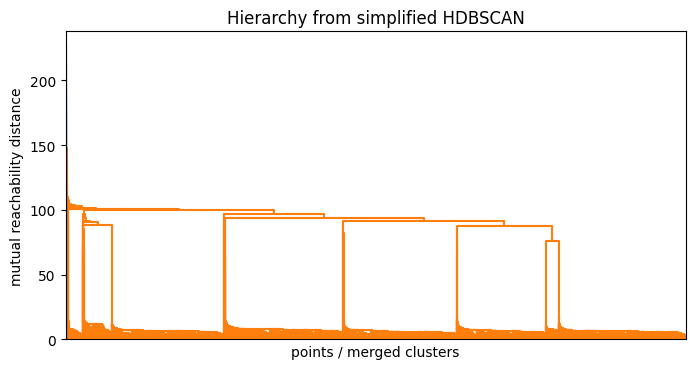

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

idx = np.random.default_rng(0).choice(len(X), size=7000, replace=False)
X_small = X[idx]


def mst_to_linkage(n_points, edges):
    # edges: list of (u, v, w)
    edges_sorted = sorted(edges, key=lambda e: e[2])
    parent = {i: i for i in range(n_points)}
    size = {i: 1 for i in range(n_points)}
    next_id = n_points
    Z = []  # linkage rows: [cluster1, cluster2, distance, new_size]

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    for u, v, w in edges_sorted:
        ru, rv = find(u), find(v)
        if ru == rv:
            continue
        new_size = size[ru] + size[rv]
        Z.append([ru, rv, w, new_size])
        parent[ru] = parent[rv] = next_id
        parent[next_id] = next_id
        size[next_id] = new_size
        next_id += 1

    return np.array(Z)

def plot_hierarchy(X, min_samples=5):
    mreach = mutual_reachability_distances(X, min_samples)
    edges = kruskal_mst(mreach)
    Z = mst_to_linkage(len(X), edges)

    plt.figure(figsize=(8, 4))
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.xlabel("points / merged clusters")
    plt.ylabel("mutual reachability distance")
    plt.title("Hierarchy from simplified HDBSCAN")
    plt.show()

plot_hierarchy(X_small, min_samples=5)

## Metrics
Simple internal metrics (silhouette, Davies-Bouldin, Calinski-Harabasz). Noise points (-1) are ignored for the metrics that require cluster membership.

**Silhouette score**
- Range: -1 to 1.
- Measures how similar a point is to its own cluster compared to other clusters.
- Higher is better: values near 1 mean points are well matched to their own cluster and far from others; values near 0 indicate overlapping clusters; negative values indicate many points might be in the wrong cluster.

**Davies-Bouldin index**
- Non-negative, lower is better.
- Compares within-cluster spread to between-cluster separation.
- A value close to 0 means compact, well-separated clusters; larger values indicate more overlap or loose clusters.

**Calinski-Harabasz index**
- Non-negative, higher is better.
- Ratio of between-cluster variance to within-cluster variance.
- Larger values indicate dense, well-separated clusters.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd


def score_all(X, labels):
    """Compute silhouette, Davies-Bouldin, and Calinski-Harabasz for a given labeling.

    Noise points (label = -1) are ignored for metrics that require cluster membership.
    """
    mask = labels >= 0
    Xc = X[mask]
    lc = labels[mask]
    unique = np.unique(lc)
    if len(Xc) == 0 or len(unique) < 2:
        return {
            'silhouette': float('nan'),
            'davies_bouldin': float('nan'),
            'calinski_harabasz': float('nan')
        }
    silhouette = silhouette_score(Xc, lc, sample_size=min(len(Xc), 4000), random_state=0) if len(Xc) > 50 else silhouette_score(Xc, lc)
    db = davies_bouldin_score(Xc, lc)
    ch = calinski_harabasz_score(Xc, lc)
    return {
        'silhouette': float(silhouette),
        'davies_bouldin': float(db),
        'calinski_harabasz': float(ch)
    }


## Compute metrics for each algorithm
## K-Means and DBSCAN are run on the full dataset X
## HDBSCAN (scratch) is run on the subset X_small, so we score that subset only.
metrics = {
    'kmeans_full': score_all(X, kmeans_labels),
    'dbscan_full': score_all(X, dbscan_labels),
    'hdbscan_scratch_subset': score_all(X_small, hdbscan_labels)
}

# Convert to a table (rows = algorithms, columns = metrics)
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df = metrics_df[['silhouette', 'davies_bouldin', 'calinski_harabasz']]

# Optionally round for nicer display
metrics_df_rounded = metrics_df.round(4)
metrics_df_rounded

IndexError: boolean index did not match indexed array along axis 0; size of axis is 12000 but size of corresponding boolean axis is 7000